<a href="https://colab.research.google.com/github/HuiningLiu02/TIF360-Advanced-machine-learning-with-neural-networks/blob/main/%E2%80%9Cdenoising_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Denoising Images with an Encoder-Decoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_1_denoising/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [ ]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
 

This notebook provides you with a complete code example that generates noisy brightfield microscopy images of particles, trains an encoder-decoder to denoise them, and visualizes the results.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Generating the Data

Define a spherical particle ...

In [ ]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64, position_unit="pixel",
    radius=lambda: (500 + np.random.rand() * 100) * dt.units.nm, #change the radius
    refractive_index=1.45 + 0.02j,
)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


... define the microscope to observe the particle ...

In [ ]:
brightfield_microscope = dt.Brightfield(
    wavelength=500 * dt.units.nm, NA=1.0, resolution=1 * dt.units.um,
    magnification=10, refractive_index_medium=1.33, upsample=2,
    output_region=(0, 0, 64, 64),
)

... obtain the image of the microscopic particle ...

In [ ]:
illuminated_sample = brightfield_microscope(particle)

... simulate the clean image of the particle ...

In [ ]:
import torch

diverse_particle = (illuminated_sample >> dt.NormalizeMinMax()
                  >> dt.MoveAxis(2, 0)
                  >> dt.pytorch.ToTensor(dtype=torch.float))

... simulate the noisy image of the particle ...

In [ ]:
noise = dt.Poisson(snr=lambda: 8.0 + np.random.rand() * 2) #imporve the snr to reduce the noise

noisy_particle = (illuminated_sample >> noise >> dt.NormalizeMinMax()
                  >> dt.MoveAxis(2, 0)
                  >> dt.pytorch.ToTensor(dtype=torch.float))

... combine the noisy and clean particle images into a single simulation pipeline ...

In [ ]:
diverse_pip = noisy_particle & diverse_particle

... and plot a few noisy and corresponding clean particle images.

In [ ]:
import matplotlib.pyplot as plt

def plot_image(title, image):
    """Plot a grayscale image with a title."""
    plt.imshow(image, cmap="gray")
    plt.title(title, fontsize=30)
    plt.axis("off")
    plt.show()

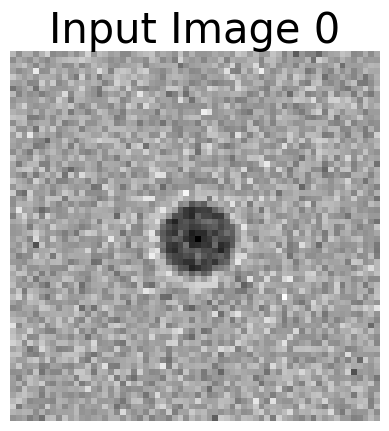

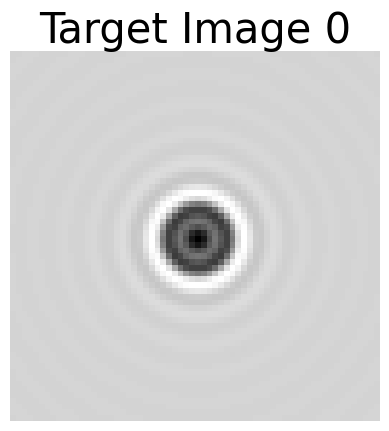

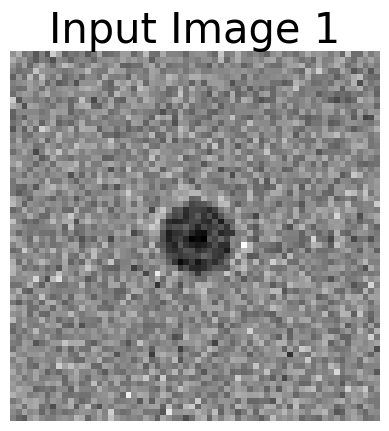

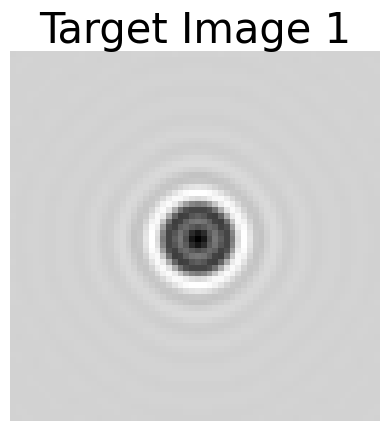

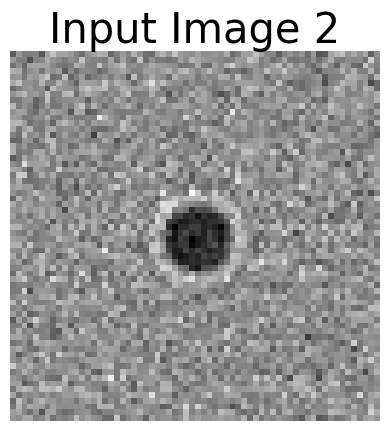

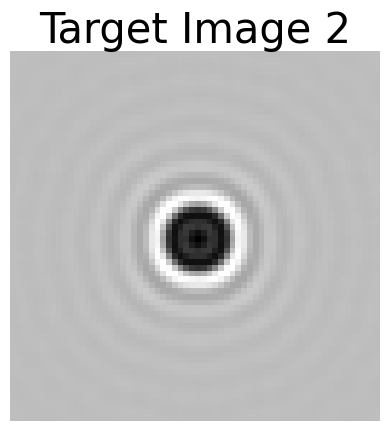

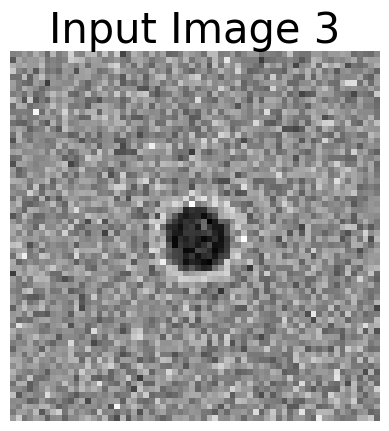

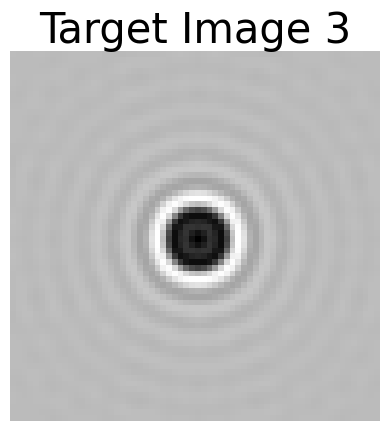

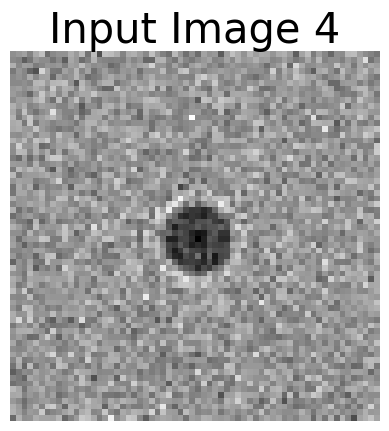

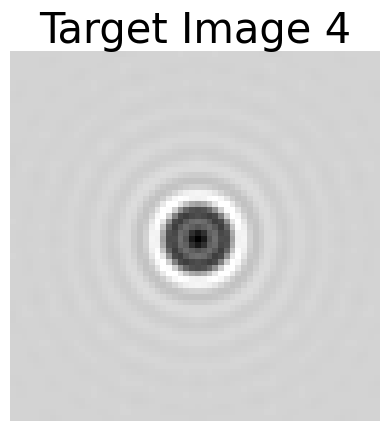

In [ ]:
for i in range(5):
    input, target = diverse_pip.update().resolve()
    plot_image(f"Input Image {i}", input.permute(1, 2, 0))
    plot_image(f"Target Image {i}", target.permute(1, 2, 0))

## Creating a Simulated Dataset

Define a class representing a simulated dataset to generate the data for the training of the denoising encoder-decoder ...

In [ ]:
class SimulatedDataset(torch.utils.data.Dataset):
    """Simulated dataset simulating pairs of noisy and clean images."""

    def __init__(self, pip, buffer_size, replace=0):
        """Initialize the dataset."""
        self.pip, self.replace = pip, replace
        self.images = [pip.update().resolve() for _ in range(buffer_size)]

    def __len__(self):
        """Return the size of the image buffer."""
        return len(self.images)

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        if np.random.rand() < self.replace:
            self.images[idx] = self.pip.update().resolve()
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0], image_pair[1]
        return noisy_image, clean_image

... and create the dataset and the data loader.

In [ ]:
dataset = SimulatedDataset(diverse_pip, buffer_size=256, replace=0.1)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

## Defining and Training the VAE

Define the variational aotuencoder ...

In [ ]:
sample = dataset[0]
print(sample[0].shape)   # print the size of the sample
print(sample[1].shape)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [ ]:
import deeplay as dl

vae = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[32, 64],
    input_size=(64, 64),
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=2, bias=True)
  (fc_var): Linear(in_features=16384, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=16384, bias=True)
  (decoder): ConvolutionalDecoder2d(
    

... and train it.

In [ ]:
vae_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
vae_trainer.fit(vae, loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K | train
1 | fc_mu               | Linear                 | 32.8 K | train
2 | fc_var              | Linear                 | 32.8 K | train
3 | fc_dec              | Linear                 | 49.2 K | train
4 | decoder             | ConvolutionalDecoder2d | 76.3 K | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   | 0      | train
-----------------

Training: |          | 0/? [00:00<?, ?it/s]

## Testing the Trained Encoder-Decoder

Denoise particle images with the trained encoder-decoder.

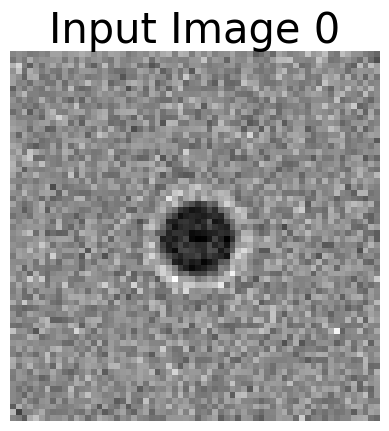

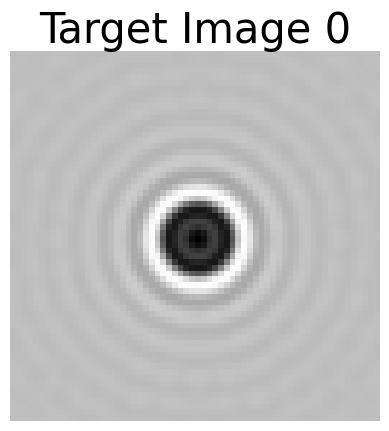

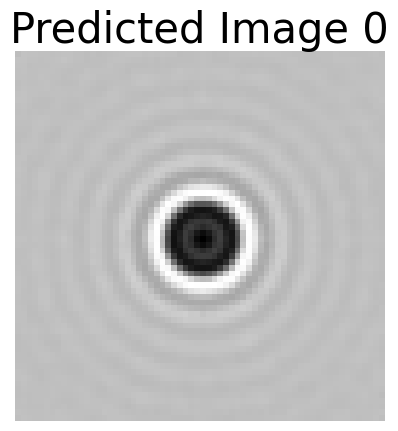

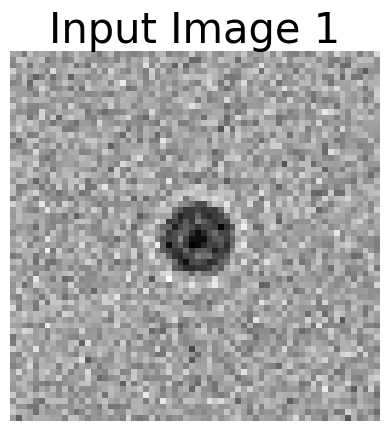

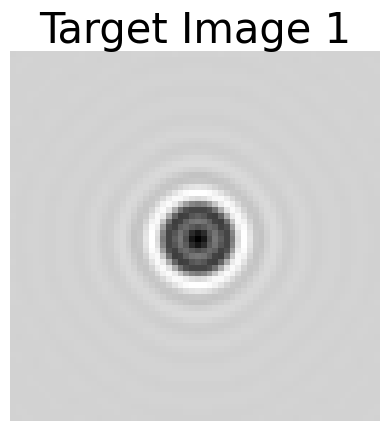

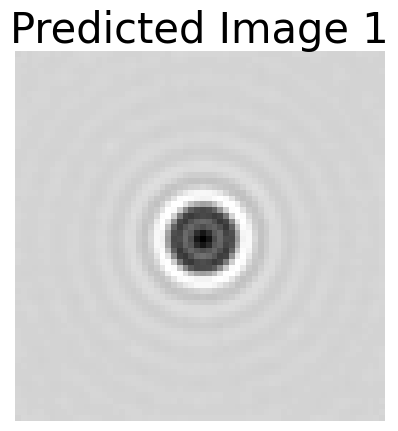

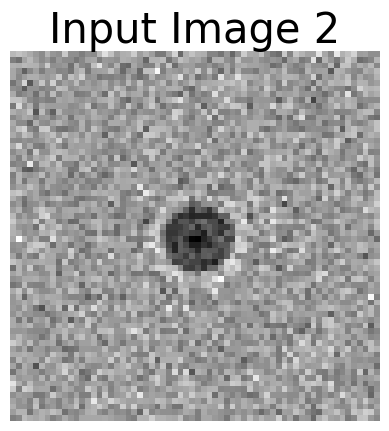

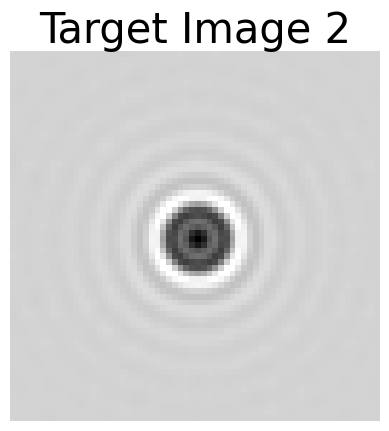

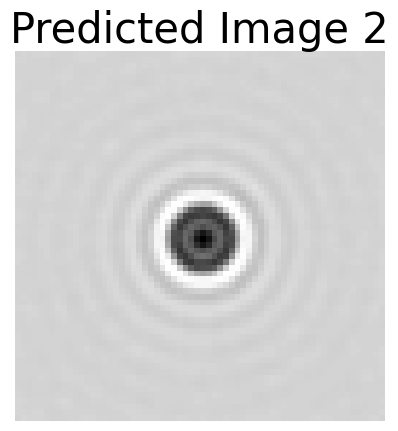

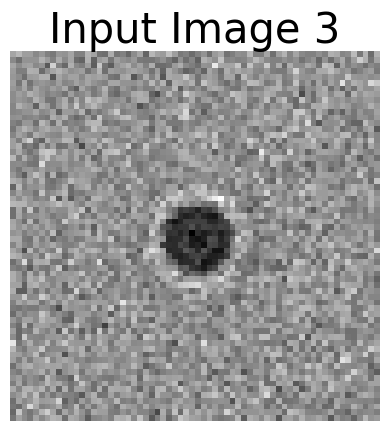

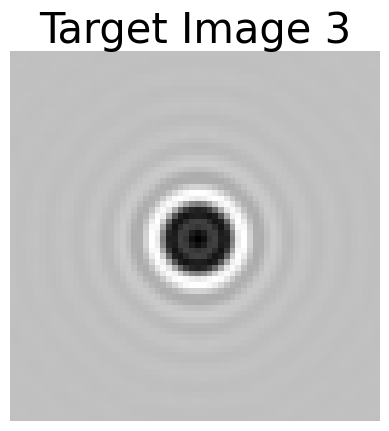

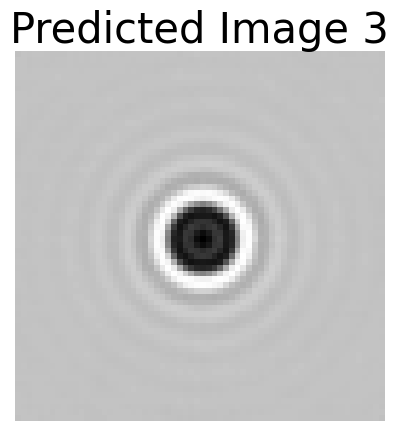

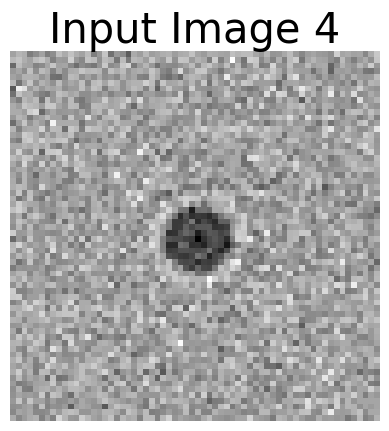

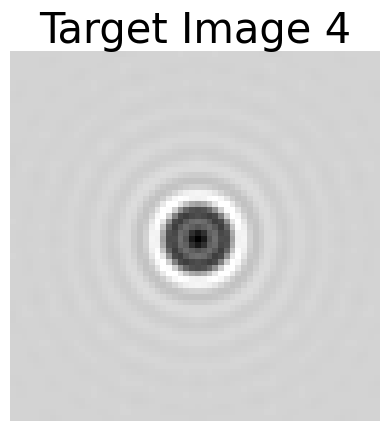

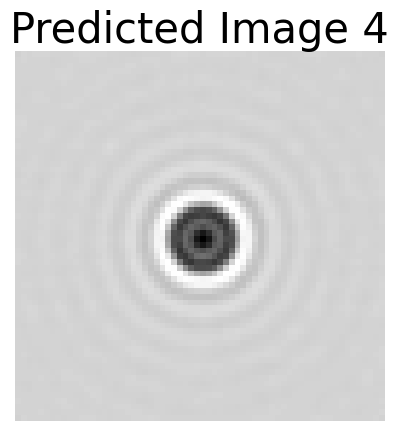

In [ ]:
for i in range(5):
    input, target = diverse_pip.update().resolve()
    predicted = vae(input.unsqueeze(0))[0].detach()

    plot_image(f"Input Image {i}", input[0, :, :])
    plot_image(f"Target Image {i}", target[0, :, :])
    plot_image(f"Predicted Image {i}", predicted[0, 0, :, :])

## Generate image of particles sampled from the latent space



define the train dataset and dataloader

In [ ]:
train_dataset = SimulatedDataset(diverse_particle & diverse_particle, buffer_size=256, replace=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
vae2 = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[32, 64],
    input_size=(64, 64),
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()
print(vae2)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=2, bias=True)
  (fc_var): Linear(in_features=16384, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=16384, bias=True)
  (decoder): ConvolutionalDecoder2d(
    

In [ ]:
vae2_trainer = dl.Trainer(max_epochs=10, accelerator="auto")
vae2_trainer.fit(vae2, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K | train
1 | fc_mu               | Linear                 | 32.8 K | train
2 | fc_var              | Linear                 | 32.8 K | train
3 | fc_dec              | Linear                 | 49.2 K | train
4 | decoder             | ConvolutionalDecoder2d | 76.3 K | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   | 0      | train
-----------------

Training: |          | 0/? [00:00<?, ?it/s]

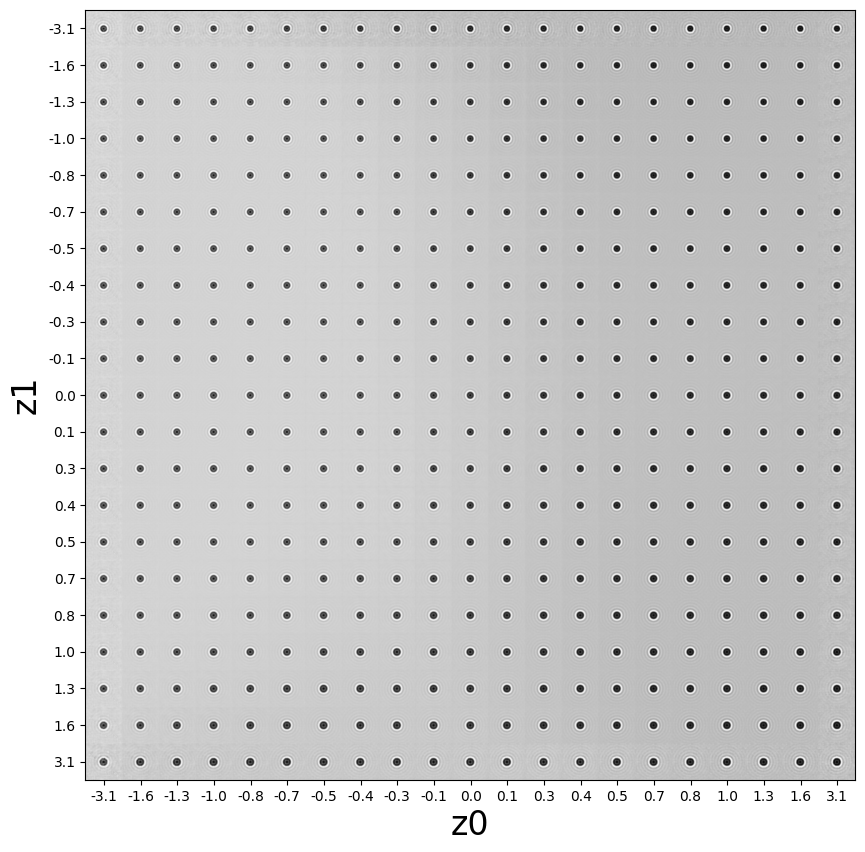

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

img_num, img_size = 21, 64
z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
      z = torch.stack((z0, z1)).unsqueeze(0)
      generated_image = vae.decode(z).clone().detach()
      image[i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size] = \
          generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.show()